In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../src")
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd
import numpy as np
from features.UserJoin import UserJoin
from features.UserJoin import (
    submit,
    diff,
    plt_month,
    plt_day,
    load_ids,
    info,
    infot,
    f1score,
)
from xgb_search_on_user_holiday import (
    day_feature_cv_col,
    hol_cv_col,
    all_col,
    hol_diff_col,
    hol_mean_col,
    hol_std_col,
    day_col,
    user_col,
    month_col,
)
import config as C
import matplotlib.pyplot as plt

from xgb_search import exp
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree
import random
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm
import itertools

sns.set_style("ticks", {"axes.grid": True})

pd.options.display.max_columns = 500
pd.options.display.max_rows = 20
pd.options.display.min_rows = 20
plt.style.use("ggplot")

In [23]:
ds = UserJoin()

In [398]:
daydf = ds.day.drop(
    columns=[
        "kwh",
        "kwh_rap",
        "   ",
        "PRC_NAME",
        "CONTRACT_CAP",
        "RUN_CAP",
        "SHIFT_NO",
        "BUILD_DATE",
        "CANCEL_DATE",
        "CHK_CYCLE",
        "LAST_CHK_DATE",
        "TMP_NAME",
        "TMP_DATE",
    ]
).reset_index()

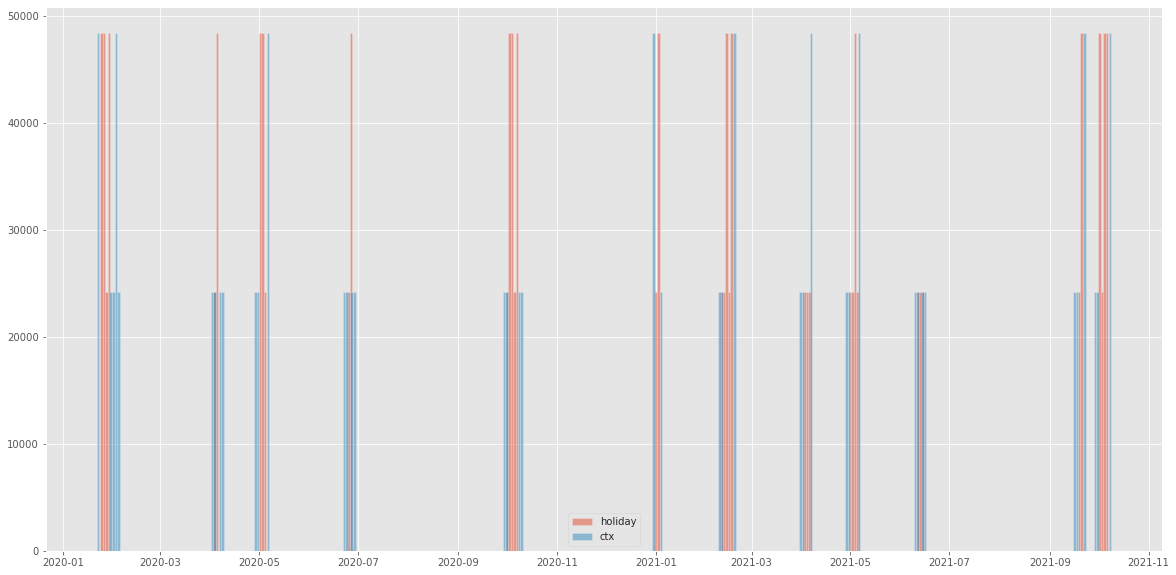

In [399]:
daydf.query("type == 0").rq.hist(bins=400, figsize=(20, 10), alpha=0.5, label="holiday")
daydf.query("type != 0").rq.hist(bins=400, figsize=(20, 10), alpha=0.5, label="ctx")
plt.legend()
plt.show()

In [402]:
# holcv_mean = ds.holiday_cv.reset_index().groupby(["id", "isminer"])
holcv_mean_subset = ds.holiday_cv[
    ds.holiday_cv.index.get_level_values(1).isin(
        C.true_ids | C.false_ids | set(C.minerids)
    )
]
holcv_mean_subset.style.background_gradient()

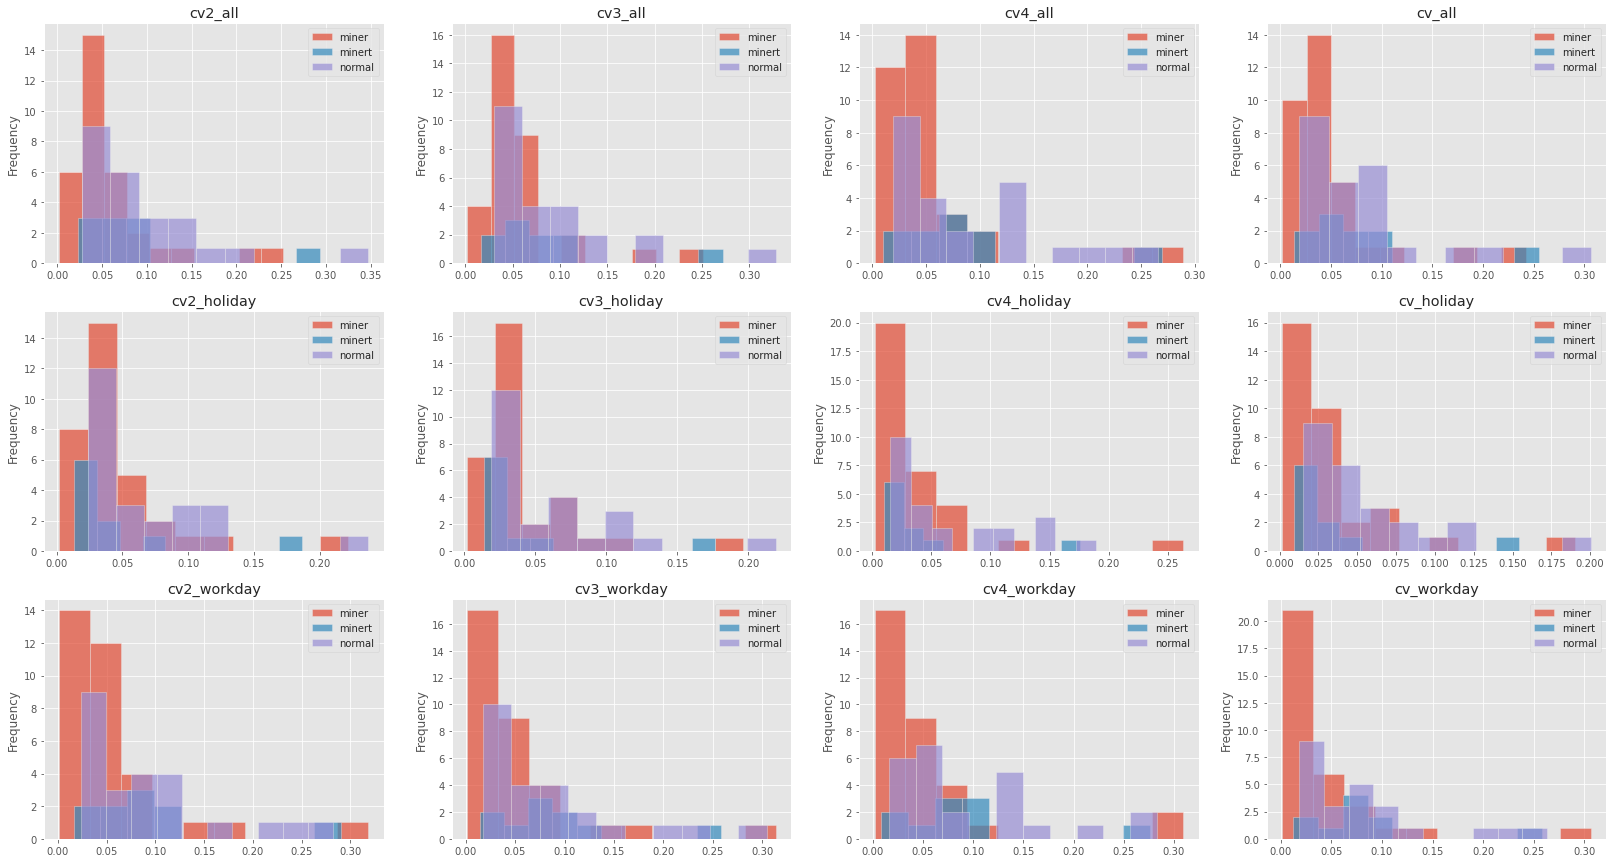

In [403]:
fig, axs = plt.subplots(3, 4, figsize=(28, 15))
for i, c in enumerate(holcv_mean_subset.columns):
    holcv_mean_subset.groupby("isminer")[c].plot(
        title=c, kind="hist", alpha=0.7, legend=True, ax=axs[int(i / 4), i % 4]
    )
plt.legend()
plt.show()

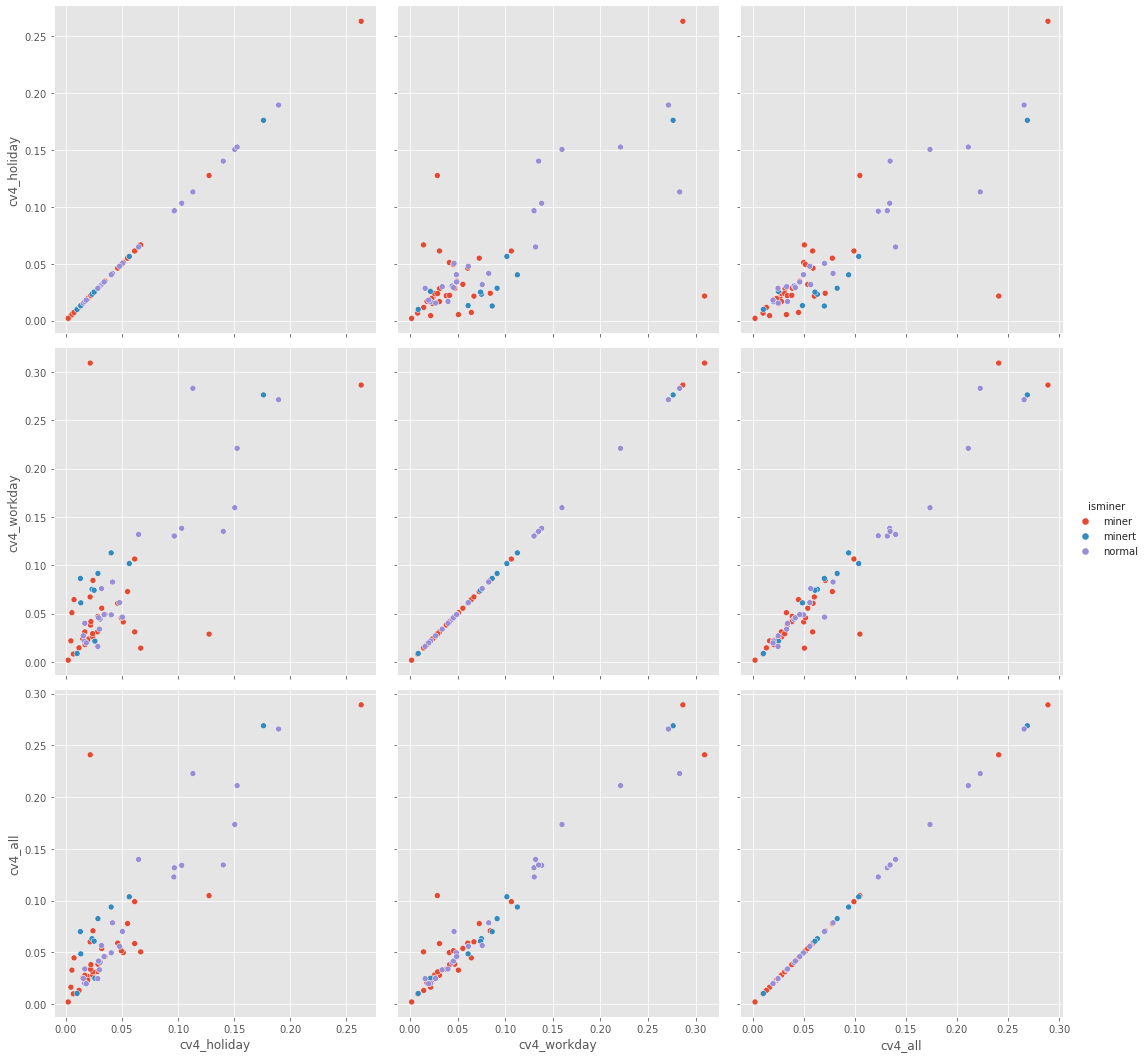

In [404]:
# plt.subplots(1, 1, figsize=(7, 7))
g = sns.PairGrid(
    data=holcv_mean_subset.reset_index()[
        ["cv4_holiday", "cv4_workday", "cv4_all", "isminer"]
    ],
    height=5,
    hue="isminer",
    # label="isminer",
)
g.map(sns.scatterplot)
g.add_legend()
# (data=holcv_mean_subset, x="cv4_holiday", y="cv4_workday", hue="isminer")

# check the model trained on user data
no compute cv group by holiday. only cv for each day (r2, r3, r4 's std/mean) and put the mean to user dataframe
could add those featuer to user dataframe too
* cv group by holiday (what `holcv_mean` do)
* cv for each column, `r2.std / r2.mean`

# let's check the model

In [406]:
modelsdf = pd.read_csv("test_on_user.csv")
modelsdf.sort_values("right_miner", ascending=0).head(10)

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
1170,10,300,0.20,0.3,0.4,29,23,4,2,"{2496032641, 179458306, 2098712195, 2479963778..."
210,3,300,0.20,0.3,0.4,29,23,4,2,"{2496032641, 179458306, 2098712195, 2479963778..."
930,8,300,0.20,0.3,0.4,29,23,4,2,"{2496032641, 179458306, 2098712195, 2479963778..."
690,6,300,0.20,0.3,0.4,29,23,4,2,"{2496032641, 179458306, 2098712195, 2479963778..."
450,5,300,0.20,0.3,0.4,29,23,4,2,"{2496032641, 179458306, 2098712195, 2479963778..."
574,6,300,0.05,0.4,0.8,28,22,5,1,"{2496032641, 179458306, 2479963778, 2212416005..."
1162,10,200,0.20,0.6,0.8,26,22,3,1,"{2496032641, 179458306, 2479963778, 2212416005..."
682,6,200,0.20,0.6,0.8,26,22,3,1,"{2496032641, 179458306, 2479963778, 2212416005..."
427,5,100,0.20,0.6,0.8,27,22,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
922,8,200,0.20,0.6,0.8,26,22,3,1,"{2496032641, 179458306, 2479963778, 2212416005..."


about .85 performance, I need to check the right_miner id with predicted by month model, check if there are small number of inner set

In [407]:
import pickle

month_preds = pickle.load(open("month_preds.dump", "rb"))
day_preds = list(
    modelsdf.sort_values("right_miner", ascending=0)
    .head(20)
    .ids.map(lambda x: eval(x))
    .values
)
inner_wrong = {1}
for mon_pred_ori in month_preds:
    mon_pred = mon_pred_ori & C.false_ids
    for day_pred in day_preds:
        day_pred = day_pred & C.false_ids
        inner_wrong = inner_wrong | (mon_pred & day_pred)

inner_wrong - {1}

{2251440776, 2451165982, 2479963778, 2602819207}

In [409]:
# 这里边两个 2251440776, 2451165982 应该可以通过 holiday cv 分辨出来。另外两个挺难的 2479963778, 2602819207
print(inner_wrong - {1})

ds.holiday_cv[
    ds.holiday_cv.index.get_level_values(1).isin(inner_wrong - {1})
].style.background_gradient()

{2251440776, 2479963778, 2451165982, 2602819207}


看了一下这些月模型和用户模型。他们的交集和并集，感觉融合一下取均值应该有效的。

In [412]:
def combine(ids):
    dfs = [pd.DataFrame({"id": list(i), "label": 1}) for i in ids]
    r = pd.concat(dfs).groupby("id").sum() / len(dfs) >= 0.5

    # print([f1score(i) for i in ids])
    print()
    newids = set(r[r.label].index.values)
    print(f1score(newids))
    print(
        f"right: {len(newids & C.true_ids)} \t wrong: {len(newids & C.false_ids)} \t unknown: {len(newids - C.true_ids - C.false_ids)} \n"
    )


combine(month_preds)
combine(day_preds)
combine(day_preds + month_preds)


0.8389324960753533
right: 28 	 wrong: 4 	 unknown: 0 


0.7543103448275863
right: 22 	 wrong: 3 	 unknown: 2 


0.821875
right: 27 	 wrong: 4 	 unknown: 0 



# 加上 holiday cv 数据重新训练

In [71]:
def train_both(df, cols, params):
    ids1, model1 = train(df, cols, params)
    ids2, model2 = train_with_imbalance(df, cols, params)

    return ids1, model1, ids2, model2


def train_with_imbalance(
    df,
    cols,
    params,
):

    if "ELEC_TYPE_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.ELEC_TYPE_NAME)], axis=1).drop(
            columns=["ELEC_TYPE_NAME"]
        )
    if "VOLT_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.VOLT_NAME)], axis=1).drop(
            columns=["VOLT_NAME"]
        )

    features = [i for i in cols if i not in ["ELEC_TYPE_NAME", "VOLT_NAME"]]
    x, x_val = (
        df.loc[df.label != "test", features],
        df.loc[df.label == "test", features],
    )

    y = df.loc[df.label != "test", "label"].astype("int")
    model = xgb.XGBClassifier(
        verbosity=1, use_label_encoder=False, eval_metric="logloss", **params
    )

    # X_resampled, y_resampled = SMOTE().fit_resample(x, y)

    X_resampled, y_resampled = ADASYN().fit_resample(x, y)
    print(X_resampled.shape)
    model.fit(X_resampled, y_resampled)

    y_val = model.predict(x_val)
    pred_val = pd.DataFrame({"id": x_val.index.values, "pred": y_val})
    ids = set(pred_val[pred_val.pred == 1].id.values)
    print(
        f"{len(ids)} \t right: {len(ids & C.true_ids)} \t wrong: {len(ids & C.false_ids)} \t unknown: {len(ids - C.true_ids - C.false_ids)}"
    )
    print("f1score", f1score(ids))
    return ids, model


def train(
    df,
    cols,
    params,
):

    if "ELEC_TYPE_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.ELEC_TYPE_NAME)], axis=1).drop(
            columns=["ELEC_TYPE_NAME"]
        )
    if "VOLT_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.VOLT_NAME)], axis=1).drop(
            columns=["VOLT_NAME"]
        )

    features = [i for i in cols if i not in ["ELEC_TYPE_NAME", "VOLT_NAME"]]
    x, x_val = (
        df.loc[df.label != "test", features],
        df.loc[df.label == "test", features],
    )

    y = df.loc[df.label != "test", "label"].astype("int")
    model = xgb.XGBClassifier(
        verbosity=1, use_label_encoder=False, eval_metric="logloss", **params
    )

    model.fit(x, y)

    y_val = model.predict(x_val)
    pred_val = pd.DataFrame({"id": x_val.index.values, "pred": y_val})
    ids = set(pred_val[pred_val.pred == 1].id.values)
    print(
        f"{len(ids)} \t right: {len(ids & C.true_ids)} \t wrong: {len(ids & C.false_ids)} \t unknown: {len(ids - C.true_ids - C.false_ids)}"
    )
    print("f1score", f1score(ids))
    return ids, model

# on train data & with hol_cv

In [646]:
from IPython.display import display


pd.read_csv("tset_on_user_holcv.csv").sort_values("right_miner", ascending=False).head(
    10
)

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
705,6,500,0.2,0.3,0.4,29,24,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
1170,10,300,0.2,0.3,0.4,31,24,6,1,"{2496032641, 179458306, 2479963778, 2212416005..."
450,5,300,0.2,0.3,0.4,31,24,6,1,"{2496032641, 179458306, 2479963778, 2212416005..."
1185,10,500,0.2,0.3,0.4,29,24,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
930,8,300,0.2,0.3,0.4,31,24,6,1,"{2496032641, 179458306, 2479963778, 2212416005..."
465,5,500,0.2,0.3,0.4,29,24,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
690,6,300,0.2,0.3,0.4,31,24,6,1,"{2496032641, 179458306, 2479963778, 2212416005..."
225,3,500,0.2,0.3,0.4,29,24,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
945,8,500,0.2,0.3,0.4,29,24,4,1,"{2496032641, 179458306, 2479963778, 2212416005..."
210,3,300,0.2,0.3,0.4,31,24,6,1,"{2496032641, 179458306, 2479963778, 2212416005..."


In [967]:
all_col = (
    []
    + hol_diff_col
    + hol_mean_col
    + hol_std_col
    + day_col
    + user_col
    + month_col
    + hol_cv_col
    # + day_feature_cv_col
)


ids1, model1, ids2, model2 = train_both(
    ds.train,
    all_col,
    {
        "max_depth": 6,
        "n_estimators": 500,
        "learning_rate": 0.2,
        "colsample_bytree": 0.3,
        "subsample": 0.4,
    },
)
len(ids2 - (C.true_ids | C.false_ids | C.ids_19_2 | C.ids_9_2))
# submit(ids2 - C.false_ids, "submit_3_17_2.csv", True)

29 	 right: 24 	 wrong: 4 	 unknown: 1
f1score 0.8111641419381614
40 	 right: 28 	 wrong: 8 	 unknown: 4
f1score 0.8142478056746274


1

# on train2 data & with all col

In [732]:
pd.read_csv("test_on_user.csv").sort_values("right_miner", ascending=False).head(10)

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
1124,10,300,0.1,1.0,1.0,47,26,8,13,"{2496032641, 179458306, 1906954499, 2479963778..."
384,5,200,0.1,0.8,0.4,46,26,7,13,"{2496032641, 179458306, 2479963778, 2520770436..."
869,8,200,0.1,1.0,1.0,47,26,8,13,"{2496032641, 179458306, 1906954499, 2479963778..."
149,3,200,0.1,1.0,1.0,47,26,8,13,"{2496032641, 179458306, 1906954499, 2479963778..."
1105,10,200,0.1,0.8,0.8,38,26,7,5,"{2496032641, 179458306, 2479963778, 2817362052..."
370,5,100,0.1,0.8,0.8,38,26,7,5,"{2496032641, 179458306, 2479963778, 2817362052..."
179,3,500,0.1,1.0,1.0,47,26,8,13,"{2496032641, 179458306, 1906954499, 2479963778..."
154,3,300,0.1,0.4,0.8,40,26,8,6,"{2496032641, 179458306, 2479963778, 2817362052..."
865,8,200,0.1,0.8,0.8,38,26,7,5,"{2496032641, 179458306, 2479963778, 2817362052..."
1139,10,500,0.1,1.0,1.0,47,26,8,13,"{2496032641, 179458306, 1906954499, 2479963778..."


In [932]:
all_col = (
    []
    # + hol_diff_col
    # + hol_mean_col
    # + hol_std_col
    # + day_col
    # + user_col
    + month_col
    # + hol_cv_col
    # + day_feature_cv_col
)

ids1, model1, ids2, model2 = train_both(
    ds.train,
    all_col,
    {
        "max_depth": 6,
        "n_estimators": 200,
        "learning_rate": 0.1,
        "colsample_bytree": 1,
        "subsample": 1,
    },
)

_ = submit(ids2 - C.false_ids, "submit_3_17_3.csv", True)

38 	 right: 26 	 wrong: 11 	 unknown: 1
f1score 0.7428571428571429
67 	 right: 31 	 wrong: 17 	 unknown: 19
f1score 0.7216991002301737
50


,id,label
0,179406029,0
1,179406030,0
2,179406094,0
3,179406097,0
4,179406099,0
5,179406175,0
6,179406176,0
7,179406179,0
8,179406180,0
9,179406223,0


In [946]:
C.ids_9_2 & C.ids_19_2

{2098712195, 2212577893, 2533183961, 2540517219}

# on train2 data & filter some cols

In [733]:
pd.read_csv("test_on_user_custom_cols_train2.csv").sort_values(
    "right_miner", ascending=False
).head(10)

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
68,3,100,0.05,0.6,1.0,28,21,5,2,"{2496032641, 179458306, 2212416005, 2251440776..."
1019,10,500,0.01,1.0,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."
59,3,500,0.01,1.0,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."
1028,10,100,0.05,0.6,1.0,28,21,5,2,"{2496032641, 179458306, 2212416005, 2251440776..."
776,8,500,0.01,0.8,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."
551,6,100,0.05,0.8,1.0,29,21,6,2,"{2496032641, 179458306, 2212416005, 2251440776..."
779,8,500,0.01,1.0,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."
536,6,500,0.01,0.8,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."
548,6,100,0.05,0.6,1.0,28,21,5,2,"{2496032641, 179458306, 2212416005, 2251440776..."
539,6,500,0.01,1.0,1.0,30,21,7,2,"{2496032641, 179458306, 2212416005, 2251440776..."


In [817]:
# dct = {"normalt": 0, "minert": 1, "unknown": -1, "miner": 1, "normal": 0}


# fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharex=True)

# t = ds.train2
# t = t[t.isminer.isin(["minert", "normalt"])]
# t["tmp"] = t.isminer.map(dct).astype("int")
# t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).head(20).iloc[1:].plot(
#     kind="barh", ax=axs[0]
# )
# print(t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).pq_g)

# t = ds.train2
# t = t[t.isminer.isin(["miner", "normal"])]
# t["tmp"] = t.isminer.map(dct).astype("int")
# t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).head(20).iloc[1:].plot(
#     kind="barh", ax=axs[1]
# )
# print(t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).pq_g)

# t = ds.train2
# t = t[t.isminer.isin(["miner", "normal", "minert", "normalt"])]
# t["tmp"] = t.isminer.map(dct).astype("int")
# t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).head(20).iloc[1:].plot(
#     kind="barh", ax=axs[2]
# )
# print(t.corr().tmp.map(lambda x: abs(x)).sort_values(ascending=False).pq_g)

# on train data with all all all columns and use imbalance

In [14]:
t = pd.read_csv("test_on_user_imbalance.csv").sort_values(
    "right_miner", ascending=False
)
t[t.right_miner > 31].sort_values("wrong_miner")

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
588,10,100,0.05,1.0,0.2,106,32,20,54,"{2212416005, 1862376457, 1429892107, 244504987..."
580,10,100,0.05,0.3,0.2,85,32,22,31,"{2212416005, 1862376457, 1429892107, 244504987..."
524,10,100,0.01,1.0,0.2,126,32,24,70,"{2212416005, 1862376457, 179461129, 1429892107..."
12,3,100,0.01,1.0,0.2,128,32,24,72,"{2212416005, 1862376457, 179461129, 1429892107..."
268,6,100,0.01,1.0,0.2,126,32,24,70,"{2212416005, 1862376457, 179461129, 1429892107..."
0,3,100,0.01,0.1,0.2,110,32,25,53,"{2852482562, 2212416005, 1862376457, 142989210..."


In [21]:
t[t.ids.map(lambda x: 2540517219 in eval(x))].sort_values(
    "right_miner", ascending=False
).head(15)

,max_depth,n_estimators,learning_rate,colsample_bytree,subsample,total,right_miner,wrong_miner,unknown,ids
0,3,100,0.01,0.1,0.2,110,32,25,53,"{2852482562, 2212416005, 1862376457, 142989210..."
524,10,100,0.01,1.0,0.2,126,32,24,70,"{2212416005, 1862376457, 179461129, 1429892107..."
12,3,100,0.01,1.0,0.2,128,32,24,72,"{2212416005, 1862376457, 179461129, 1429892107..."
580,10,100,0.05,0.3,0.2,85,32,22,31,"{2212416005, 1862376457, 1429892107, 244504987..."
268,6,100,0.01,1.0,0.2,126,32,24,70,"{2212416005, 1862376457, 179461129, 1429892107..."
588,10,100,0.05,1.0,0.2,106,32,20,54,"{2212416005, 1862376457, 1429892107, 244504987..."
240,3,1000,0.50,0.1,0.2,56,31,15,10,"{2496032641, 179458306, 2098712195, 2479963778..."
320,6,100,0.05,0.1,0.2,89,31,24,34,"{2212416005, 1862376457, 1429892107, 244504987..."
196,3,100,0.50,0.3,0.2,50,31,10,9,"{2496032641, 179458306, 2098712195, 2479963778..."
288,6,500,0.01,0.1,0.2,97,31,25,41,"{2212416005, 1862376457, 1429892107, 244504987..."


# imbalance & autoxgb

In [68]:
t = pd.read_csv("test_predictions.csv")
ids = set(t[t.minert >= 0.5].id.unique())

print(len(ids & C.true_ids), len(ids & C.false_ids))
# len(ids - C.true_ids - C.false_ids - C.ids_3_1)

30 13


# tmp

In [76]:
all_col = (
    []
    # + hol_diff_col
    # + hol_mean_col
    # + hol_std_col
    + day_col
    # + user_col
    # + month_col
    + hol_cv_col
    + day_feature_cv_col
)

ids1, model1, ids2, model2 = train_with_imbalance(
    ds.train,
    all_col,
    {
        # "max_depth": 6,
        # "n_estimators": 200,
        # "learning_rate": 0.1,
        # "colsample_bytree": 0.5,
        # "subsample": 0.5,
    },
)

# _ = submit(ids2 - C.false_ids, "submit_3_17_3.csv", True)

(17660, 39)
60 	 right: 30 	 wrong: 21 	 unknown: 9
f1score 0.7423217074440396


ValueError: not enough values to unpack (expected 4, got 2)

TMP FOR IMPORTANCE

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

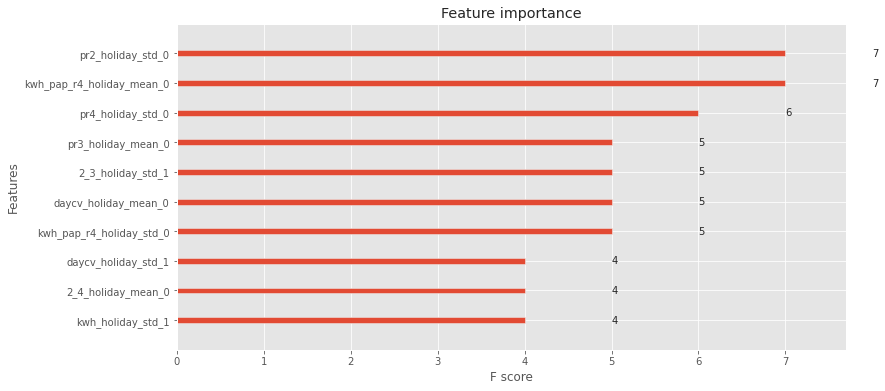

In [734]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_importance(model, ax=ax, max_num_features=10)